# Generating IC's

In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import os
import power as power

We start by generating some white noise $n(\mathbf{x})$

In [2]:
size = 30 # Mpc/h
n_grid = 64
n_grid_half = n_grid // 2
key, noise_key = jax.random.split(jax.random.PRNGKey(1))
rho = jax.random.normal(noise_key, (n_grid, n_grid, n_grid))

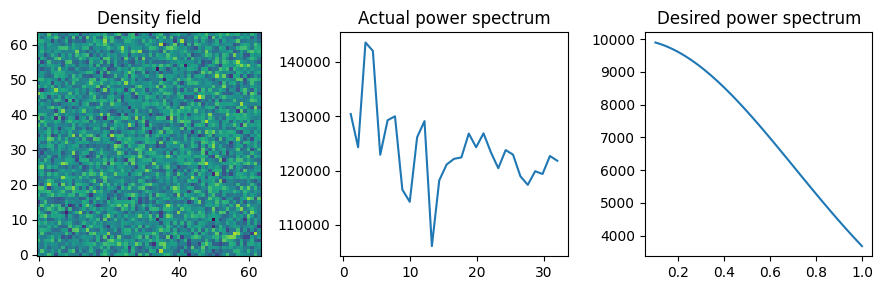

In [3]:
delta = power.overdensity(rho)

power_spectrum = power.PowerSpectrum(N = n_grid, n_bins=30)

k, Pk = power_spectrum(delta)

# lets define a desired power spectrum
k_desired = jnp.linspace(0.1, 1.0, n_grid)
Pk_desired = 1e4 * jnp.exp(-k_desired**2)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(delta[n_grid//2], origin='lower')
ax1.set_title('Density field')
ax2.plot(k, Pk)
ax2.set_title('Actual power spectrum')
ax3.plot(k_desired, Pk_desired)
ax3.set_title('Desired power spectrum')

plt.tight_layout()


According to Pen et al. (1997), we need to compute the correlation Kernel

$$ 
A(k) = \sqrt{P(k)}.
$$

Then we can convolve the white noise with the correlation Kernel to generate the IC's 

$$
\delta(\mathbf{x}) = n(\mathbf{x}) \otimes A(\mathbf{x}).
$$


In [4]:
# lets compute the correlation Kernel
Ax_lin = jnp.sqrt(Pk_desired)

coords = jnp.linspace(0, n_grid, n_grid, endpoint=False)
x, y, z = jnp.meshgrid(coords, coords, coords, indexing='ij')
index_grid = jnp.sqrt(x**2 + y**2 + z**2)
index_grid -= n_grid_half
index_grid = jnp.abs(index_grid)
index_grid = index_grid.astype(jnp.int32)

Ax = Ax_lin.at[index_grid].get()

# delta = jax.scipy.signal.convolve(delta, Ax, mode='full', method='auto')

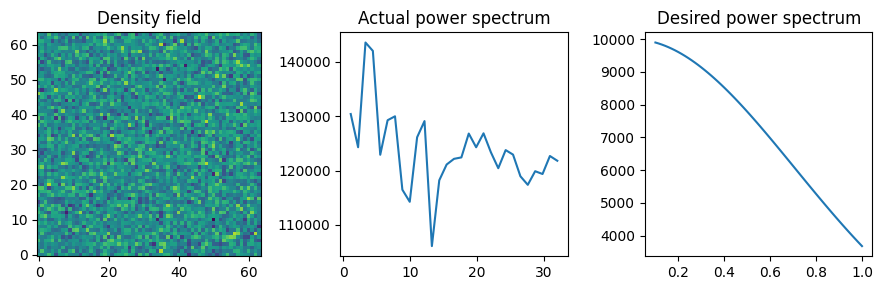

In [5]:
k, Pk = power_spectrum(delta)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(delta[n_grid//2], origin='lower')
ax1.set_title('Density field')
ax2.plot(k, Pk)
ax2.set_title('Actual power spectrum')
ax3.plot(k_desired, Pk_desired)
ax3.set_title('Desired power spectrum')

plt.tight_layout()